# BOVW模型的处理过程：

1. SIFT特征提取。SIFT 特征提取是求出图像的关键点信息，包括角度，大小以及强度。关键点，也就是能够代表图像关键信息的部分，这也是Bag of words中单词的组成。一个图像通常有很多的关键点。

2. 聚类。我们将每幅图像中的关键点信息添加到词袋中，并定义聚类中心的数量N。然后将词袋中的关键点通过Kmeans算法聚类到N个类中。同时得到这N个类的中心点组成N*128的dictionary，每个中心都可以代表这个类。

3. 求图像的直方图。将图像的关键点信息重新放到词包中，根据落在每个类中关键点的数量来得到图像的直方图，大小为1*N。将每幅图像进行处理，得到图像在BOW模型下的特征。

4. 图像匹配。将测试图像进行相同的处理，同样也得到1*N的特征。根据测试图像与训练图像特征之间的距离，并将距离较小的图像作为检索的结果。



# データ確認（KIMIA_Path_20クラス*48枚=960）

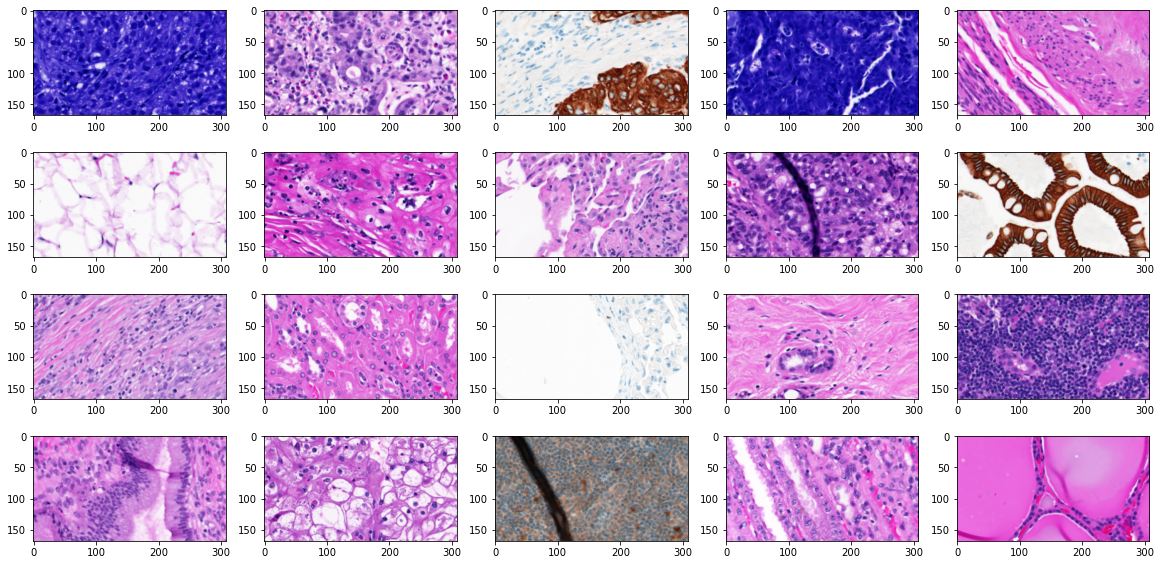

In [1]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt

load = "../Database/KIMIA_Path_960/train/"
classes = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T"]

fig, ax = plt.subplots(2,2, figsize = (20,10))
for n in range(20):
    img = cv2.imread(load+classes[n]+"10.tif")
    plt.subplot(4,5,n+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# データの読み込み

In [2]:
load = "../Database/KIMIA_Path_960/train"
all_files=[]
file_label=[]

for root,dirs,files in os.walk(load):
    for file_name in files:
        file = os.path.join(root,file_name)
        label = os.path.join(file_name)
        all_files.append(file)
        file_label.append(label[0])
all_files.remove("../Database/KIMIA_Path_960/train/.DS_Store")
file_label.remove(".")
print(len(all_files))
print(len(file_label))

960
960


# 特徴点の抽出

In [3]:
k = 20
detector = cv2.xfeatures2d.SIFT_create()
trainer = cv2.BOWKMeansTrainer(k)
keypoints = []
directors = []
for file in all_files:
    image = cv2.imread(file)
    ks, ds = detector.detectAndCompute(image, None)
    trainer.add(ds.astype(np.float32))
    keypoints.append(ks)
    directors.append(ds)
print("keypoints: ",len(keypoints))

keypoints:  960


In [21]:
len(directors[1][1])

128

# クラスタリング

In [4]:
dictionary = trainer.cluster()
print("dictionary: ",dictionary.shape)

dictionary:  (20, 128)


In [5]:
len(dictionary[1])

128

# 提言する表現方法

In [22]:
import math

def eculidDisSim(x,y):
    '''
    欧几里得相似度计算方法
    '''
    return math.sqrt(sum(pow(a-b,2) for a,b in zip(x,y)))

def cosSim(x,y):
    '''
    余弦相似度计算方法
    '''
    tmp=sum(a*b for a,b in zip(x,y))
    non=np.linalg.norm(x)*np.linalg.norm(y)
    return round(tmp/float(non),3)


In [29]:
cat = []
hist = []
dis = []
cos = []
for i in range(20):
    cat.append([])
    hist.append(0)
    dis.append([])
    cos.append([])

print(cos)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [31]:
len(directors[1])

1000

In [33]:
for point in directors[1]:
    point_dis = 999999999
    for i in range(len(dictionary)):
        if point_dis > eculidDisSim(point, dictionary[i]):
            point_dis = eculidDisSim(point, dictionary[i])
            point_cat = i
    cat[point_cat].append(point)
    dis[point_cat].append(point_dis)
    hist[point_cat] += 1
    cos[point_cat].append(cosSim(point, dictionary[point_cat]))

In [41]:
descriptor = []
for i in range(len(dictionary)):
    descriptor.append(hist[i]/len(directors[1]))
    descriptor.append(np.mean(dis[i])/1000)
    descriptor.append(np.mean(cos[i]))

print(descriptor)

[0.037, 0.32803945026419196, 0.765972972972973, 0.03, 0.3450689095042317, 0.7369666666666668, 0.039, 0.33349538910254656, 0.7562820512820513, 0.043, 0.332577419130549, 0.7586511627906977, 0.02, 0.31561921613289534, 0.7856, 0.051, 0.33376678372479457, 0.7562352941176471, 0.048, 0.3120861537920084, 0.7883958333333334, 0.065, 0.3252084674970876, 0.7700769230769231, 0.02, 0.33442944476441283, 0.7541000000000001, 0.087, 0.31472605095850487, 0.78483908045977, 0.063, 0.33765826826280354, 0.7486507936507937, 0.028, 0.33598597006073905, 0.7517142857142857, 0.048, 0.3454152566735597, 0.7355, 0.187, 0.26952123446915327, 0.8473636363636363, 0.036, 0.33603373908878975, 0.75225, 0.067, 0.34066320240319464, 0.7435671641791044, 0.045, 0.3303944443463866, 0.7613333333333334, 0.014, 0.34410876156000164, 0.7392857142857142, 0.042, 0.33834701333974604, 0.7484285714285716, 0.03, 0.33129563733307443, 0.7616666666666667]


In [46]:
from tqdm import trange
import time

In [ ]:
def descriptor_new(IMG):
    image = cv2.imread(IMG)
    ks, ds = detector.detectAndCompute(image, None)
    cat = []
    hist = []
    dis = []
    cos = []
    for i in range(20):
        cat.append([])
        hist.append(0)
        dis.append([])
        cos.append([])

    for point in ds:
        point_dis = 999999999
        for i in range(len(dictionary)):
            if point_dis > eculidDisSim(point, dictionary[i]):
                point_dis = eculidDisSim(point, dictionary[i])
                point_cat = i
        cat[point_cat].append(point)
        dis[point_cat].append(point_dis)
        hist[point_cat] += 1
        cos[point_cat].append(cosSim(point, dictionary[point_cat]))

    descriptor = []
    for i in range(len(dictionary)):
        descriptor.append(hist[i]/len(ds))
        descriptor.append(np.mean(dis[i])/1000.0)
        descriptor.append(np.mean(cos[i]))
        
    for i in range(0,60,3):
        descriptor[i] = descriptor[i]*10
    
    return descriptor

In [ ]:
img = "../Database/KIMIA_Path_960/train/C24.tif"
new = descriptor_new(img)

suma=0
for i in range(0,60,3):
    suma+=new[i]
suma

10.0

In [ ]:
# all_descriptor = []

for n in trange(960):
    time.sleep=0.01    
    cat = []
    hist = []
    dis = []
    cos = []
    for i in range(20):
        cat.append([])
        hist.append(0)
        dis.append([])
        cos.append([])

    for point in directors[n]:
        point_dis = 999999999
        for i in range(len(dictionary)):
            if point_dis > eculidDisSim(point, dictionary[i]):
                point_dis = eculidDisSim(point, dictionary[i])
                point_cat = i
        cat[point_cat].append(point)
        dis[point_cat].append(point_dis)
        hist[point_cat] += 1
        cos[point_cat].append(cosSim(point, dictionary[point_cat]))

    descriptor = []
    for i in range(len(dictionary)):
        descriptor.append(hist[i]/len(directors[n]))
        descriptor.append(np.mean(dis[i])/1000.0)
        descriptor.append(np.mean(cos[i]))
        
    all_descriptor.append(descriptor)


  2%|▏         | 16/960 [02:32<2:29:35,  9.51s/it]/Users/alpaca/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alpaca/.local/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 960/960 [2:21:28<00:00,  8.84s/it]  


In [ ]:
all_descriptor = np.array(all_descriptor)

In [ ]:
all_descriptor.shape

(960, 60)

In [ ]:
all_descriptor[0]=all_descriptor[1]

In [ ]:
# 出现回数合計＝10

for m in range(960):
    for i in range(0,60,3):
        all_descriptor[m][i] = all_descriptor[m][i]*10
#     des[np.isnan(des)]=0

In [ ]:
suma=0

for m in range(1):
    for i in range(0,60,3):
#         all_descriptor[1][i] = all_descriptor[1][i]/10
        suma+=all_descriptor[m][i]
suma

10.000000000000002

In [ ]:
# 出现回数合計＝１００

for m in range(960):
    for i in range(0,60,3):
        all_descriptor[m][i] = all_descriptor[m][i]/10

In [ ]:
suma=0

for m in range(1):
    for i in range(0,60,3):
#         all_descriptor[1][i] = all_descriptor[1][i]/10
        suma+=all_descriptor[m][i]
suma

100.0

In [ ]:
all_descriptor[0]

array([ 3.7       ,  0.32803945,  0.76597297,  3.        ,  0.34506891,
        0.73696667,  3.9       ,  0.33349539,  0.75628205,  4.3       ,
        0.33257742,  0.75865116,  2.        ,  0.31561922,  0.7856    ,
        5.1       ,  0.33376678,  0.75623529,  4.8       ,  0.31208615,
        0.78839583,  6.5       ,  0.32520847,  0.77007692,  2.        ,
        0.33442944,  0.7541    ,  8.7       ,  0.31472605,  0.78483908,
        6.3       ,  0.33765827,  0.74865079,  2.8       ,  0.33598597,
        0.75171429,  4.8       ,  0.34541526,  0.7355    , 18.7       ,
        0.26952123,  0.84736364,  3.6       ,  0.33603374,  0.75225   ,
        6.7       ,  0.3406632 ,  0.74356716,  4.5       ,  0.33039444,
        0.76133333,  1.4       ,  0.34410876,  0.73928571,  4.2       ,
        0.33834701,  0.74842857,  3.        ,  0.33129564,  0.76166667])

# ヒストグラム

In [6]:
matcher = cv2.BFMatcher()
extractor = cv2.BOWImgDescriptorExtractor(detector, matcher)
extractor.setVocabulary(dictionary)
descriptor_list = []
for file in all_files:
    image = cv2.imread(file)
    ks = detector.detect(image, None)
    descriptor = extractor.compute(image, ks)[0]
    descriptor_list.append(descriptor)

print("descriptor: ",type(descriptor))
print("descriptor: ",descriptor.shape)
print("descriptor_list: ",type(descriptor_list))
print("descriptor_list: ",len(descriptor_list))

descriptor:  <class 'numpy.ndarray'>
descriptor:  (20,)
descriptor_list:  <class 'list'>
descriptor_list:  960


In [ ]:
descriptor_list

[array([0.02454705, 0.09760374, 0.04558738, 0.03974284, 0.00642899,
        0.03156049, 0.03974284, 0.05260082, 0.02571595, 0.01052016,
        0.15488018, 0.08240794, 0.0414962 , 0.01402688, 0.01052016,
        0.05084746, 0.16014026, 0.04441847, 0.0490941 , 0.01811806],
       dtype=float32),
 array([0.037     , 0.03      , 0.039     , 0.043     , 0.02      ,
        0.051     , 0.048     , 0.06500001, 0.02      , 0.087     ,
        0.063     , 0.028     , 0.048     , 0.187     , 0.036     ,
        0.067     , 0.045     , 0.014     , 0.042     , 0.03      ],
       dtype=float32),
 array([0.03414097, 0.02973568, 0.05286343, 0.05286343, 0.07599118,
        0.0561674 , 0.09801762, 0.03524229, 0.04295154, 0.03854625,
        0.03524229, 0.05726872, 0.07048458, 0.05947136, 0.04845815,
        0.07268722, 0.02753304, 0.02863436, 0.03744493, 0.04625551],
       dtype=float32),
 array([0.04444445, 0.04962963, 0.03259259, 0.04444445, 0.03259259,
        0.05185185, 0.03555556, 0.03407408, 

# 近似画像検索

In [7]:
def similar(img):
    image = cv2.imread(img)
    ks = detector.detect(image, None)
    descriptor = extractor.compute(image, ks)[0]
    simi_dis=[]
    for i in range(len(descriptor_list)): 
        matches = matcher.match(descriptor,descriptor_list[i])
        dist_matches = [m.distance for m in matches]
        simi_dis.append(np.mean(dist_matches))
    simi_file = zip(simi_dis, all_files)
    return sorted(simi_file)

>> 検索元画像


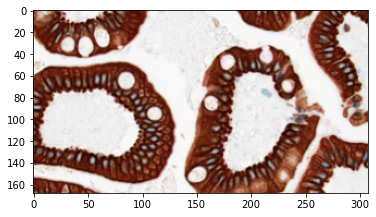

>> 検索結果


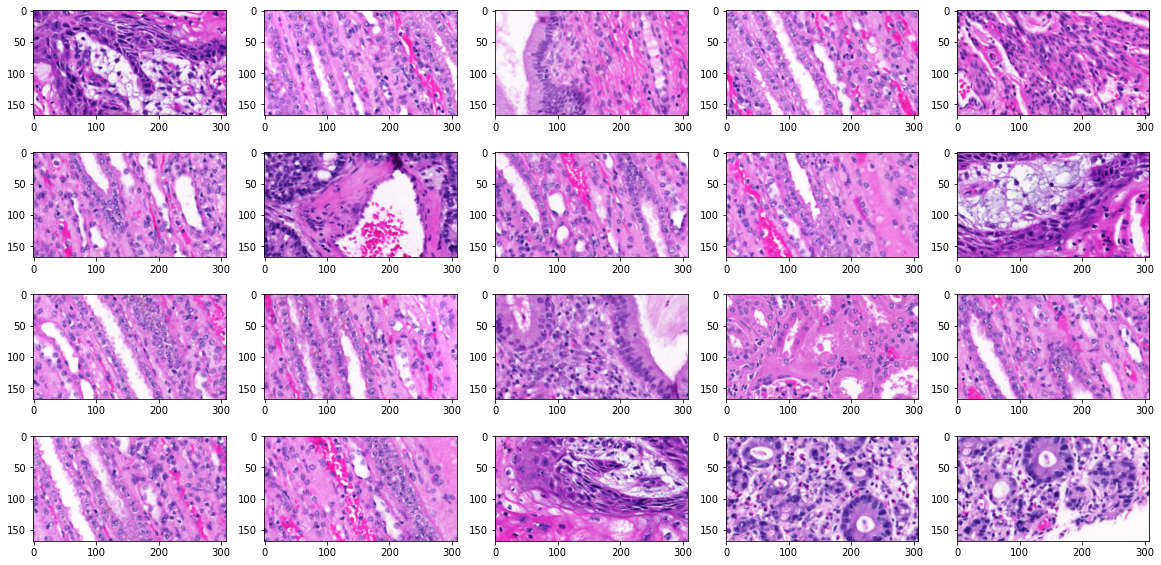

In [ ]:
img = "../Database/KIMIA_Path_960/test/J48.tif"
print(">> 検索元画像")
img1 = cv2.imread(img)
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

simi_list = similar(img)
print(">> 検索結果")
fig, ax = plt.subplots(2,2, figsize = (20,10))
for i in range(20):
    img = cv2.imread(simi_list[i][1])
    plt.subplot(4,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 新結果

In [ ]:
print(len(descriptor))

60


In [ ]:
def similar(img):
    descriptor = descriptor_new(img)
    print(descriptor)
    matches = []
    for i in range(960): 
        matches.append(eculidDisSim(descriptor,all_descriptor[i]))
    simi_file = zip(matches, all_files)
    return sorted(simi_file)

In [ ]:
img = "../Database/KIMIA_Path_960/train/a20.tif"
simi_list = similar(img)
print(simi_list)

[0.552536231884058, 0.30658330163049413, 0.799, 0.7427536231884058, 0.32924651346834827, 0.7642926829268293, 0.40760869565217395, 0.33123224568175175, 0.7616222222222221, 0.3804347826086957, 0.32280554433622083, 0.7745714285714287, 0.15398550724637683, 0.32944240850770684, 0.7651764705882353, 0.35326086956521735, 0.3305601284907443, 0.7624358974358975, 0.1721014492753623, 0.32406787505846674, 0.774, 0.2717391304347826, 0.3145253796085047, 0.7878333333333334, 0.7971014492753623, 0.3068076973991255, 0.7988636363636363, 0.552536231884058, 0.3248223039925025, 0.7710983606557377, 1.0960144927536233, 0.32351832992138374, 0.7738595041322314, 0.6068840579710145, 0.32930893235376596, 0.7640298507462687, 0.5615942028985508, 0.3286510833971141, 0.765258064516129, 0.1721014492753623, 0.3252598464112533, 0.7711052631578948, 0.2536231884057971, 0.3197761693423931, 0.7799642857142858, 0.4528985507246377, 0.32413466492368365, 0.7722, 1.1503623188405796, 0.3144913202921031, 0.7874173228346457, 0.760869

In [ ]:
img = "../Database/KIMIA_Path_960/train/t20.tif"
simi_list = similar(img)
print(simi_list)

[0.3463203463203463, 0.31005790689771356, 0.794, 0.38961038961038963, 0.31565933825805564, 0.7861666666666666, 0.5411255411255411, 0.32626911639915707, 0.76912, 0.6060606060606061, 0.3187907301912587, 0.7814642857142858, 0.5411255411255411, 0.29964120384501525, 0.8091200000000001, 0.6926406926406926, 0.31791067105979504, 0.7830625, 0.5411255411255411, 0.3072341368070563, 0.79716, 0.3246753246753247, 0.3194884482939531, 0.7806666666666668, 0.367965367965368, 0.30237230712778507, 0.8062941176470588, 0.19480519480519481, 0.3217020536196387, 0.7775555555555556, 0.367965367965368, 0.32122565362921807, 0.7771176470588235, 0.6493506493506493, 0.33171188559451664, 0.7606333333333335, 0.5411255411255411, 0.3182029576235018, 0.7822, 0.30303030303030304, 0.3088703022416503, 0.7957142857142857, 0.6926406926406926, 0.3067912104881939, 0.799625, 0.670995670995671, 0.3253669127919134, 0.7706451612903227, 0.2813852813852814, 0.3195663658081717, 0.7805384615384614, 0.3463203463203463, 0.315441356582659

../Database/KIMIA_Path_960/train/S5.tif


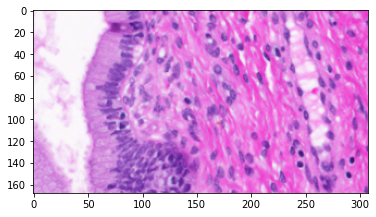

In [ ]:
print(simi_list[2][1])
img = cv2.imread(simi_list[1][1])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

>> 検索元画像


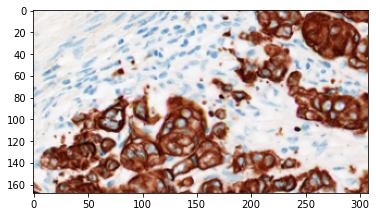

>> 検索結果


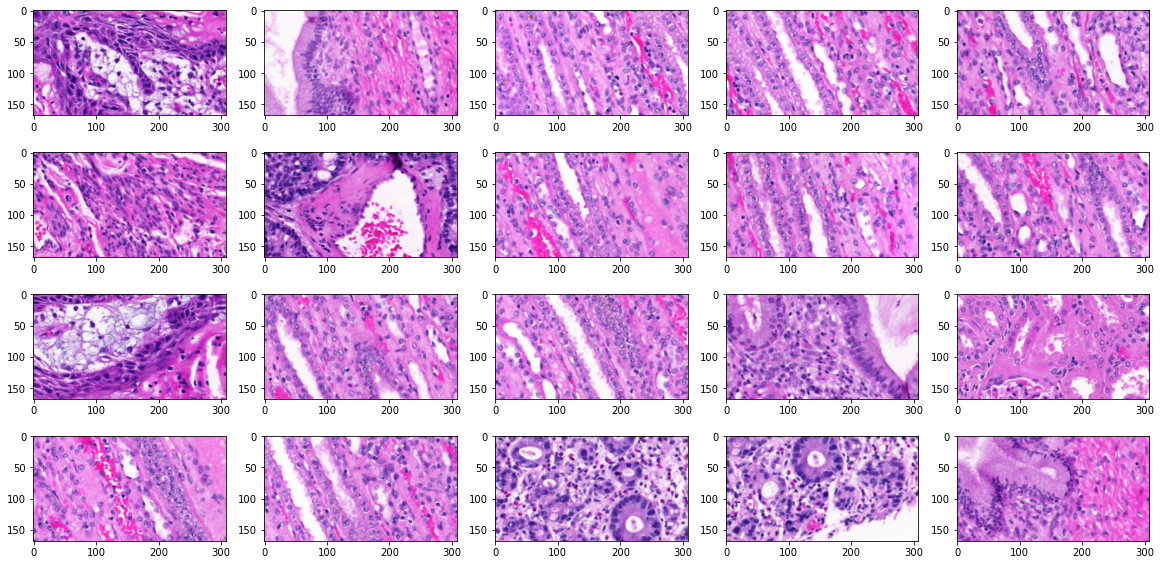

In [ ]:
img = "../Database/KIMIA_Path_960/train/C24.tif"
print(">> 検索元画像")
img1 = cv2.imread(img)
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

simi_list = similar(img)
print(">> 検索結果")
fig, ax = plt.subplots(2,2, figsize = (20,10))
for i in range(20):
    img = cv2.imread(simi_list[i][1])
    plt.subplot(4,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# BPNN画像分類

In [7]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [23]:
descriptor_data = np.array(descriptor_list)
file_label_int = LabelEncoder().fit(file_label).transform(file_label)

X_train, X_test, y_train, y_test = train_test_split(descriptor_data, file_label_int, test_size=0.3, random_state=42)
print("Train: ",type(X_train),X_train.shape,type(y_train),y_train.shape,"\nTest: ",type(X_test),X_test.shape,type(y_test),y_test.shape)

Train:  <class 'numpy.ndarray'> (672, 20) <class 'numpy.ndarray'> (672,) 
Test:  <class 'numpy.ndarray'> (288, 20) <class 'numpy.ndarray'> (288,)


In [24]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(20, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.fit(X_train, y_train, epochs=30)

Epoch 1/30
21/21 [==============================] - 0s 919us/step - loss: 2.9781 - accuracy: 0.1457
Epoch 2/30
21/21 [==============================] - 0s 963us/step - loss: 2.8862 - accuracy: 0.2683
Epoch 3/30
21/21 [==============================] - 0s 1ms/step - loss: 2.7148 - accuracy: 0.2630
Epoch 4/30
21/21 [==============================] - 0s 1ms/step - loss: 2.4966 - accuracy: 0.2439
Epoch 5/30
21/21 [==============================] - 0s 1ms/step - loss: 2.1951 - accuracy: 0.3579
Epoch 6/30
21/21 [==============================] - 0s 1ms/step - loss: 1.9092 - accuracy: 0.5060
Epoch 7/30
21/21 [==============================] - 0s 1ms/step - loss: 1.7155 - accuracy: 0.5835
Epoch 8/30
21/21 [==============================] - 0s 1ms/step - loss: 1.5747 - accuracy: 0.5423
Epoch 9/30
21/21 [==============================] - 0s 1ms/step - loss: 1.4686 - accuracy: 0.6411
Epoch 10/30
21/21 [==============================] - 0s 1ms/step - loss: 1.3518 - accuracy: 0.6522
Epoch 11/30
21/

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

9/9 [==============================] - 0s 929us/step - loss: 0.7617 - accuracy: 0.7743

Test accuracy: 0.7743055820465088


# 画像類別予測

In [34]:
def classify(load, img):
    print(">>",img)
    image = cv2.imread(load+img)
    ks = detector.detect(image, None)
    descriptor = extractor.compute(image, ks)[0]
    prediction = model.predict(descriptor.reshape(1,-1))
    predict_label = classes[np.argmax(prediction)]
    print(">> This IMG's label is "+predict_label)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    print(">> CLASS"+predict_label+": 上皮細胞")
    

>> 上皮細胞.png
>> This IMG's label is B


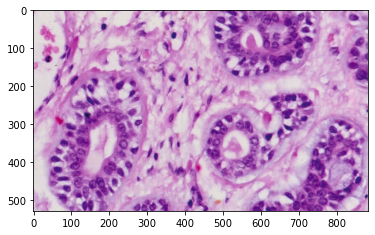

>> CLASSB: 上皮細胞


In [35]:
load = "../Database/KIMIA_Path_960/test/"
img = "上皮細胞.png"
classify(load, img)